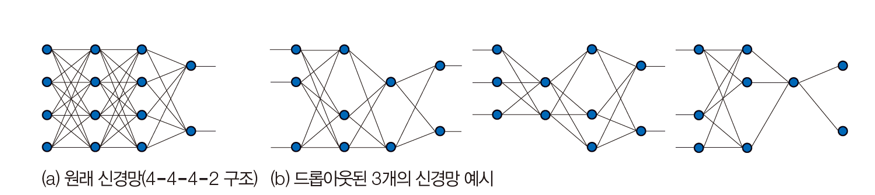

In [1]:
# 드랍아웃
# 일정 비율의 가중치를 임의로 선택하고 불능( 제로셋팅) 만들어서 학습하는 규제
# 랜덤하게 노드를 선택
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/56.PNG", width=500)

In [2]:
# 교차검증을 실시하여 신뢰성을 높임(드랍아웃)
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold

In [3]:
# 데이터 준비
(x_train,y_train),(x_target,y_target) = cifar10.load_data()
x_train = x_train / 255.0 ; x_target = x_target / 255.0
y_train = tf.keras.utils.to_categorical(y_train,10)
y_target = tf.keras.utils.to_categorical(y_target,10)

170508288/170498071 [==============================] - 3s 0us/step


In [4]:
# 하이퍼매개변수 - 나중에 튜닝 대상 파라메터 --> 해당 매개변수의 값에 따라 성능차이를 보이는 매개변수
batch_size = 128
n_epoch = 10
k = 5
x_train.shape

(50000, 32, 32, 3)

In [7]:
# 드랍아웃 비율에 따라서 교차 검증을 수행하고 정확률을 반환
from tensorflow.keras.losses import categorical_crossentropy
def cross_validation(dropout_rate):
  accuracy = []
  for train_index, val_index in  KFold(k).split(x_train):
    xtrain, xval = x_train[train_index], x_train[val_index]  # 학습용 데이터, 검증용 데이터
    ytrain, yval = y_train[train_index], y_train[val_index]  # 학습용의 정답, 검증용의 정답

    # 신경망 설계  C-C-P-D C-C-P-D-FC-D-FC   
    # 32 (3,3)  64(3,3)            512  10
    # relu                              softmax 
    # dropout은 dropout_rate[0]  dropout_rate[1]  dropout_rate[2]
    cnn=Sequential()  # 신경망 객체생성
    cnn.add( Conv2D(32,(3,3), activation='relu',input_shape = (32,32,3) )  )
    cnn.add( Conv2D(32,(3,3), activation='relu' )  )
    cnn.add(MaxPool2D(pool_size=(2,2)))
    cnn.add(Dropout(dropout_rate[0]))

    cnn.add( Conv2D(64,(3,3), activation='relu' )  )
    cnn.add( Conv2D(64,(3,3), activation='relu' )  )
    cnn.add(MaxPool2D(pool_size=(2,2)))
    cnn.add(Dropout(dropout_rate[1]))

    cnn.add(Flatten())                      # 신경망의 입력층
    cnn.add(Dense(512,activation='relu'))   # 신경망의 은닉층
    cnn.add(Dropout(dropout_rate[2]))       # 드랍아웃
    cnn.add(Dense(10,activation='softmax'))   # 신경망의 출력층

    # 신경망 모델 학습하고 평가
    cnn.compile(loss = categorical_crossentropy, optimizer = Adam(), metrics=['accuracy'])
    cnn.fit(xtrain,ytrain,batch_size=batch_size,epochs=n_epoch,validation_data=(xval,yval),verbose = 1)
    accuracy.append(cnn.evaluate(xval,yval))
  return accuracy

In [8]:
# 드랍아웃 비율을 변경하면서 신경망을 평가
widthout_dropout = cross_validation([0.0,0.0,0.0])  #  정수보다는 실수형태로 전달하면 내부알고리즘에 의해서.. 계산 속도가 빨라진다.
with_dropout = cross_validation([0.25,0.25,0.5])


Epoch 1/10
313/313 [==============================] - 8s 25ms/step - loss: 1.5918 - accuracy: 0.4166 - val_loss: 1.2933 - val_accuracy: 0.5359
Epoch 2/10
313/313 [==============================] - 6s 20ms/step - loss: 1.2228 - accuracy: 0.5663 - val_loss: 1.1398 - val_accuracy: 0.5917
Epoch 3/10
313/313 [==============================] - 7s 22ms/step - loss: 1.0288 - accuracy: 0.6381 - val_loss: 0.9963 - val_accuracy: 0.6474
Epoch 4/10
313/313 [==============================] - 7s 21ms/step - loss: 0.8867 - accuracy: 0.6905 - val_loss: 0.8938 - val_accuracy: 0.6873
Epoch 5/10
313/313 [==============================] - 7s 21ms/step - loss: 0.7639 - accuracy: 0.7330 - val_loss: 0.8549 - val_accuracy: 0.7031
Epoch 6/10
313/313 [==============================] - 7s 21ms/step - loss: 0.6496 - accuracy: 0.7736 - val_loss: 0.8407 - val_accuracy: 0.7089
Epoch 7/10
313/313 [==============================] - 7s 21ms/step - loss: 0.5397 - accuracy: 0.8140 - val_loss: 0.8494 - val_accuracy: 0.7158

In [ ]:
print(f"드랍아웃 적용 안할때 {np.mean(widthout_dropout)}")
print(f"드랍아웃 적용 할때 {np.mean(with_dropout)}")

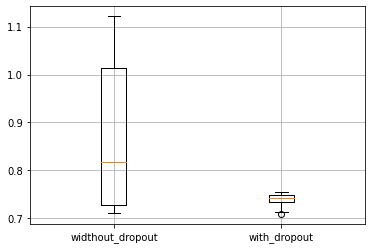

In [12]:
# 박스 플롯으로 정확률 표시
import matplotlib.pyplot as plt
widthout_dropout2 = np.array(widthout_dropout).reshape(-1,)
with_dropout2 = np.array(with_dropout).reshape(-1,)
plt.grid()
plt.boxplot([widthout_dropout2, with_dropout2], labels = ['widthout_dropout', 'with_dropout'])
plt.show()

In [ ]:
# 가중치 감쇠 : 성능을 유지한 채로 가중치 크기를 낮추는 규제
# 손실함수중에 평균제곱오차(MSE) -->  가중치 감소를 적용  대표적인게  L1(라소) / L2(리지) 규제

In [ ]:
# 텐서플로 에서 가중치 감쇠
# 매개변수 조정으로 ....
# kernel_regularizer(가중치에 적용)
# Bias_regularizer(바이어스 적용)
# Activity_regularizer(활성 함수 결과에 적용)

# 사용법
from tensorflow.keras import regularizers
model = Sequential()
# -----
# model.add(Dense(64, kernel_regularizer =regularizers.l2(0.01),   ))

In [ ]:
# 성능평가 중요성
# 하이퍼 매개변수 최적화나 모델 선택에 중요
# 현장 설치여부를 판단 -- 납품

#객관적인 평가 방법
# 교차검증 : 데이터를 분할해서 여러번 반복해서 통계적으로 신뢰성을 높이

#제거조사 ablation study
# 여러 선택사항이 있을때 선택사항을 하나씩 빼고 성능을 측정해서 최적의 기여도를 평가